# EMD Metric Exploration Notebook

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# suppress info and warn TF logs
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import time
import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import voxelmorph as vxm
import tensorflow as tf
import nibabel as nib
import neurite as ne
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
from stabilize2p.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    std = video[0].std()
    print('calculated std')
    low = np.quantile(video[0], q=0.01)
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

In [3]:
orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.tif'
]

ofco_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
]

RANDOM_SEED = 1

## `scipy.optimize`

Check [this post](https://math.stackexchange.com/questions/318038/monte-carlo-for-the-wasserstein-metric/320414#320414?newreg=766ff9bf9af341ef8b96dfcf738c002c)

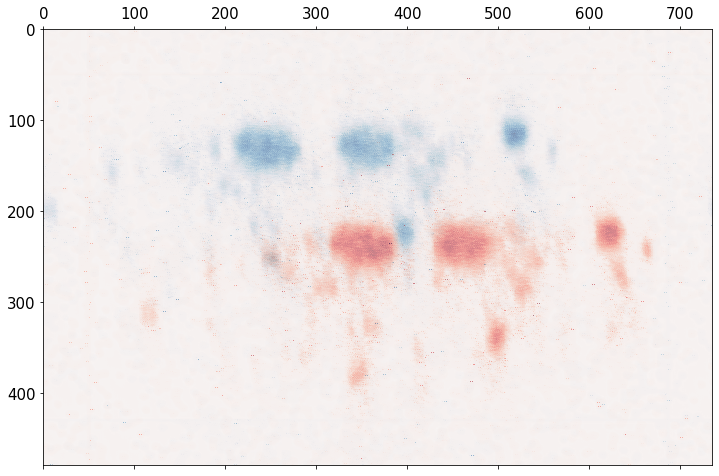

In [4]:
from scipy import ndimage as ndi
video = tiff.imread(orig_examples[1], key=[100, 101])

I, J = video
I = ndi.shift(I, (-50, -50), mode='grid-wrap')
J = ndi.shift(J, (50, 50), mode='grid-wrap')

_, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.matshow(I, cmap='Blues')
ax.matshow(J, cmap='Reds', alpha=0.5)
plt.show()

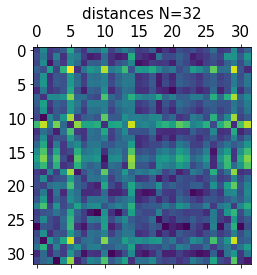

Elapsed: 3.5769s
EMD: 99.08568820927218


In [74]:
from scipy.spatial.distance import cdist
from scipy import sparse
import scipy.optimize

N = 32
metric = 'euclidean'

def EMD(I, J, N=32, metric='euclidean'):
    # make frames probability distributions
    I = I - I.min()
    J = J - J.min()
    I = I / I.sum()
    J = J / J.sum()
    I_flat = I.flatten()
    J_flat = J.flatten()

    I_idx = np.random.choice(I_flat.size, p=I_flat, size=N)
    J_idx = np.random.choice(J_flat.size, p=J_flat, size=N)

    I_pts = np.c_[np.unravel_index(I_idx, I.shape)]
    J_pts = np.c_[np.unravel_index(J_idx, J.shape)]

    D = cdist(I_pts, J_pts, metric=metric)

    _, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.matshow(D)
    plt.title(f'distances N={N}')
    plt.show()

    # Linear Program
    # want to maximize, so c is negative
    c = - 1 / N * np.concatenate([np.ones(N), -np.ones(N)], axis=0)

    # construct A matrix
    A = np.empty(shape=(0, 2*N), dtype=int)
    for sign in [1, -1]:
        for i in range(N):
            M = np.c_[sign * np.tile((np.arange(N) == i).astype(int), (N, 1)),
                      -sign * np.eye(N, dtype=int)] 
            A = np.r_[A, M]

    # construct b array
    b = np.r_[D.ravel(), D.ravel()]

    t1 = time.perf_counter()
    res = scipy.optimize.linprog(c, A_ub=A, b_ub=b, bounds=(None, None))
    W_1 = - c @ res.x
    t2 = time.perf_counter()
    print(f'Elapsed: {t2-t1:.4f}s')

    return W_1, I_pts, J_pts

print(f'EMD: {EMD(I, J, N=N, metric=metric)[0]}')

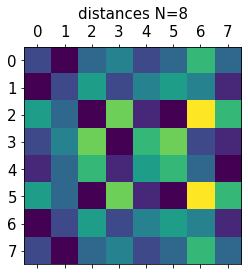

Elapsed: 0.2229s
(8, 1) (8, 1)


/tmp/ipykernel_3253094/4093999381.py:46: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  res = scipy.optimize.linprog(c, A_ub=A, b_ub=b, bounds=(None, None))
/tmp/ipykernel_3253094/4093999381.py:46: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  res = scipy.optimize.linprog(c, A_ub=A, b_ub=b, bounds=(None, None))
/home/adrian/miniconda3/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.3564e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/adrian/miniconda3/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py

(0.7499999999976485, 0.75)

In [70]:
from scipy.stats import wasserstein_distance
# np.random.seed(1)
a = np.random.normal(size=10)
b = np.random.normal(size=10)

emd, a_pts, b_pts = EMD(a, b, N=8)

print(a_pts.shape, b_pts.shape)

scipy_emd = wasserstein_distance(a_pts.ravel(), b_pts.ravel())

emd, scipy_emd

In [131]:
from scipy.optimize import linear_sum_assignment


def loop(I, J, n_samples=2048, metric='euclidean'):
    # make frames probability distributions
    I = I - I.min()
    J = J - J.min()

    I = I / I.sum()
    J = J / J.sum()

    I_flat = I.flatten()
    J_flat = J.flatten()

    # sample random points
    I_idx = np.random.choice(I_flat.size, p=I_flat, size=n_samples)
    J_idx = np.random.choice(J_flat.size, p=J_flat, size=n_samples)

    I_pts = np.c_[np.unravel_index(I_idx, I.shape)]
    J_pts = np.c_[np.unravel_index(J_idx, J.shape)]

    # calculate minimum distance assignment
    d = cdist(I_pts, J_pts, metric=metric)
    assignment = linear_sum_assignment(d)

    return d[assignment].sum() / n_samples, I_pts, J_pts

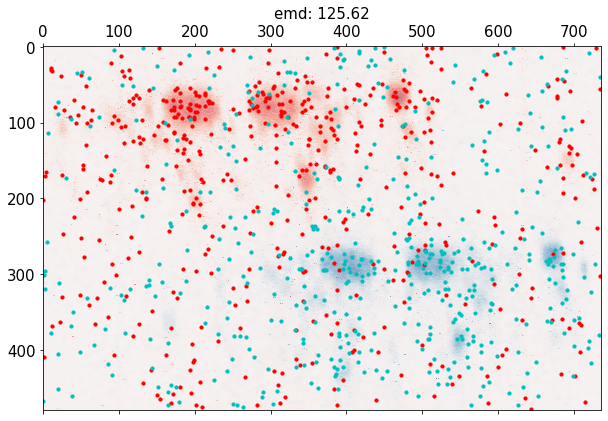

In [159]:
from stabilize2p.metrics import EMD

def get_IJ(muI, muJ, sigmaI = 10, sigmaJ = 10):
    W, H = 400, 400
    # [2, W, H]
    xy = np.stack(np.meshgrid(np.arange(H), np.arange(W)))
    muI = np.array(muI)[:, np.newaxis, np.newaxis]
    muI2 = np.array([100, 300])[:, np.newaxis, np.newaxis]
    muJ = np.array(muJ)[:, np.newaxis, np.newaxis]
    muJ2 = np.array([200, 300])[:, np.newaxis, np.newaxis]
    # error terms
    epsI = np.random.normal(size=(H, W)) * 0.01
    epsJ = np.random.normal(size=(H, W)) * 0.01
    I = np.exp(- np.sum((xy - muI)**2, axis=0) / (2.0 * sigmaI**2))*0.5
    I += np.exp(- np.sum((xy - muI2)**2, axis=0) / (2.0 * sigmaI**2)) + epsI
    J = np.exp(- np.sum((xy - muJ)**2, axis=0) / (2.0 * sigmaJ**2))*0.5
    J += np.exp(- np.sum((xy - muJ2)**2, axis=0) / (2.0 * sigmaJ**2)) + epsJ
    return I, J

# I, J = get_IJ([100, 100], [300, 300])

video = tiff.imread(orig_examples[1], key=[100, 101])

s = 100

I, J = video
I = ndi.shift(I, (-s, -s), mode='grid-wrap')
J = ndi.shift(J, (s, s), mode='grid-wrap')
#

emd, I_pts, J_pts = loop(I, J, 500)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plotI = ax.matshow(I, cmap='Reds')
plotJ = ax.matshow(J, alpha=0.5, cmap='Blues')

scI = ax.scatter(I_pts[:, 1], I_pts[:, 0], c='r', s=10);
scJ = ax.scatter(J_pts[:, 1], J_pts[:, 0], c='c', s=10);

plt.title(f'emd: {emd:.2f}')
plt.show()

In [160]:
from stabilize2p.metrics import EMD
video = tiff.imread(orig_examples[1], key=range(200))
t1 = time.perf_counter()
emd = EMD(video, n_samples=500)
t2 = time.perf_counter()
print(f'EMD: {emd} | Elapsed {t2-t1:.2f}s | {video.shape[0] / (t2-t1) :,.0f} frames/s')

EMD: 31.236420371565597 | Elapsed 4.17s | 48 frames/s
